# Wikipedia Lightdump EDA

*Exploratory data analysis of Wikipedia edit data (lightdump format) to explore conflict and controversiality through proxy of edit wars.*

By Darren Liu and Casey Duong

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Set Up
Importing necessary libraries and setting up databases and tables for EDA. 

In [1]:
#import necessary libraries
import sys
import json
import seaborn as sns
import numpy as np

#add paths to access custom library features
sys.path.insert(0, '../src/features')

#import custom library features
from build_features import *

#read the config file
with open('../config/eda-params.json') as f:
    eda_config = json.load(f)
    
outdir = eda_config['outdir']
db_fp = eda_config['db_infp']

#read in database as DataFrame
articles_df = query_articles(db_fp)

#change type to int so we can aggregate
articles_df['num_edits'] = articles_df['num_edits'].astype(int)
articles_df['m'] = articles_df['m'].astype(int)

## Base Descriptive Statistics

First, let's take a look at the count of articles on English Wikipedia and the distribution of number of edits.

In [2]:
print("There are", str(len(articles_df)), "on English Wikipedia")

There are 4644531 on English Wikipedia


In [3]:
#descriptive stats for num edits
articles_df['num_edits'].describe()

count    4.644531e+06
mean     4.733238e+01
std      2.174465e+02
min      0.000000e+00
25%      3.000000e+00
50%      1.100000e+01
75%      3.100000e+01
max      4.365000e+04
Name: num_edits, dtype: float64

Histogram of distribution of edits for 25% of data

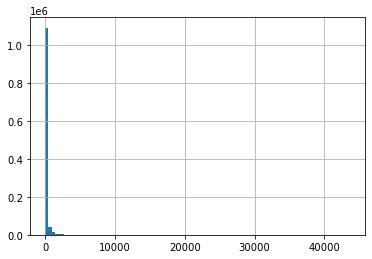

In [9]:
#histogram of distribution of edits for 25% of data
articles_df.loc[articles_df['num_edits'] > 31]['num_edits'].hist(bins = 100)

Now, let's take a look at the distributions of the M-statistics (and number of edits) for all English Wikipedia pages. We found that the minimum, 25th, 50th, and 75th percentile were all zero.

In [10]:
articles_df['m'].describe()

count    4.644531e+06
mean     3.376670e+01
std      5.331740e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.302744e+06
Name: m, dtype: float64

When we exclude values of zero, the above percentiles shift to 2, 4, 8, and 36, still significantly lower than our maximum of about 8.3 million.

In [11]:
articles_df.loc[articles_df['m'] > 0]['m'].describe()

count    2.159580e+05
mean     7.262083e+02
std      2.471596e+04
min      2.000000e+00
25%      4.000000e+00
50%      8.000000e+00
75%      3.600000e+01
max      8.302744e+06
Name: m, dtype: float64

Out of the 4.64 million articles in English Wikipedia, roughly 4.43 million pages had an M-stat of zero. This shows that most of Wikipedia actually consists of non-frequented stubs. In contrast, approximately 216,000 pages had both an M-stat greater than zero and more than zero edits. We can see that the majority of traffic and contributions is based around 4.65% of pages, if not less since we included pages with little edits as long as they were greater than zero.

In [12]:
total_pages = len(articles_df)
m_zero = articles_df.loc[articles_df['m'] == 0]
non_zero_m_edits = len(articles_df.loc[(articles_df['m'] > 0) &\
                          (articles_df['num_edits'] > 0)])

print("Total English Wikipedia pages:", total_pages)
print("\n")

print("Pages with M-stat of 0:", len(m_zero))
print("Pages with M-stat of 0 and edit count > 0:",
     len(m_zero.loc[m_zero['num_edits'] > 0]))
print("\n")

print("Pages with M-stat and edit count > 0:", non_zero_m_edits)
print("Proportion of pages with M-stat and edit count > 0:",
      non_zero_m_edits/total_pages)

Total English Wikipedia pages: 4644531


Pages with M-stat of 0: 4428573
Pages with M-stat of 0 and edit count > 0: 4428494


Pages with M-stat and edit count > 0: 215958
Proportion of pages with M-stat and edit count > 0: 0.04649726743130792


To plot the M-stat distribution, we took the log of the M-stat, for all pages with an M-stat greater than zero, to make the output graph more consumable. The histogram shows us that the distribution of log M-stat is unimodal with a long tail on the right (high M-stats).

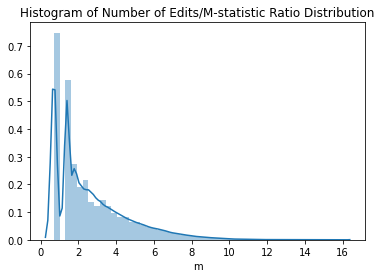

In [14]:
log_m = np.log(articles_df[articles_df['m'] > 0]['m'])

hs = sns.distplot(log_m)
hs.set_title('Histogram of Number of Edits/M-statistic Ratio Distribution',
             fontsize=12);

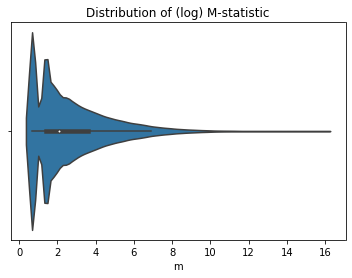

In [15]:
vp = sns.violinplot(log_m)
vp.set_title('Distribution of (log) M-statistic', fontsize=12);

Let's take a look at the relationship between number of edits and M-statistic. Since there's about 4.43 million articles, this would take a long time to plot (especially since they're just plotting for M-stat = 0), so we'll only look at pages with an M-stat of greater than 0.

In a scatter plot comparing M-stat and number of edits per article, we see that the distribution of both M-stats and edit counts is primarily clustered towards the lower end of the spectrum, with several higher scoring pages and one extremely high scoring page.

In [16]:
nonzero = articles_df.loc[articles_df['m'] > 0]

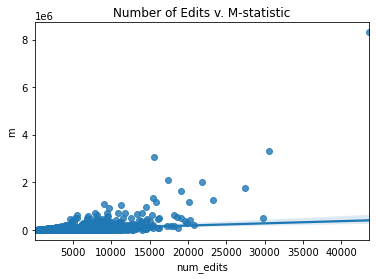

In [17]:
sc = sns.regplot(data = nonzero, x = 'num_edits', y = 'm')
sc.set_title('Number of Edits v. M-statistic');

## Top 100 M-statistic Articles

The “George W Bush” Wikipedia page boasts the highest M-stat at 8,302,744 and the highest edit count at 43,650. This is significantly larger than the second most controversial page, “List of World Wrestling Entertainment employees”, referred to as “List of WWE employees” henceforth, which has an M-stat of 3,301,500 and 30,572 edits. In addition, the “List of WWE employees” contains information about hundreds of individuals connected to World Wrestling Entertainment while “George W Bush” only includes the history of a single person, though at a greater depth than “List of WWE employees”.

In [19]:
top_100_edited = articles_df.sort_values('num_edits', ascending = False).head(100)

top_100_m = articles_df.sort_values('m', ascending = False).head(100)

top_100_zero = articles_df.sort_values(['m', 'num_edits'], ascending = [True, False]).head(100)

We cross referenced the top 100 M-stat pages versus the top 100 most edited pages. There were 40 pages in both top 100 lists. We then identify 3,933 as the lowest M-stat of the highest 100 M-stats in the entirety of English Wikipedia, which has a 75th percentile of 36, less than one-tenth of the 100th highest M-statistic. Again, this affirms the slight scale of edit warring compared to the large scale of Wikipedia.

Controversial (high m-score) pages in the top 100 edited pages

In [22]:
top_100_m.loc[top_100_m['article_name'].isin(top_100_edited['article_name'].tolist())].describe()

,num_edits,m
count,40.000000,4.000000e+01
mean,17532.050000,9.867287e+05
std,6223.834217,1.403996e+06
min,11836.000000,1.921500e+05
25%,13925.500000,3.419465e+05
50%,15423.000000,4.930595e+05
75%,19211.500000,1.184450e+06
max,43650.000000,8.302744e+06


Controversial (high m-score) pages not in the top 100 edited pages

In [23]:
top_100_m.loc[~top_100_m['article_name'].isin(top_100_edited['article_name'].tolist())].describe()

,num_edits,m
count,60.000000,6.000000e+01
mean,7773.033333,3.952223e+05
std,2115.525346,2.009411e+05
min,3933.000000,1.929330e+05
25%,6359.000000,2.432865e+05
50%,7802.000000,3.421480e+05
75%,9414.500000,4.931520e+05
max,11479.000000,1.104600e+06


We see a recurring trend of topics among the pages with the 10 highest M-statistics: political figures and themes, religion, and celebrities. These pages all have an M-stat of at least 1 million and at least 15,000 edits per page. We can also see that higher edit count does not necessarily imply higher M-stat, as is the case with “Michael Jackson” versus “Muhammad”, where the less edited page (Muhammad) actually has a higher M-stat. 

In [24]:
top_20_edited.head(10)

,article_id,article_name,num_edits,m
3414502,3414502,George_W._Bush,43650,8302744
3713374,3713374,List_of_World_Wrestling_Entertainment_employees,30572,3301500
3046640,3046640,Wikipedia,29726,509838
3409788,3409788,United_States,27433,1764520
1462060,1462060,Michael_Jackson,23243,1268295
4128673,4128673,Jesus,21768,2016080
657296,657296,Deaths_in_2009,20814,189390
4400411,4400411,Wii,20225,424999
3595633,3595633,Adolf_Hitler,20093,1184326
4642517,4642517,Britney_Spears,19833,300125


To further explore this, we examined the ratio of the log of the M-stat to the number of edits per article. This gave us a similar distribution to the original logarithmic M-statistic distribution, but smoothed out the distribution and reducing the tail, indicating that there are articles with high edit counts compared to their low(er) M-statistic.

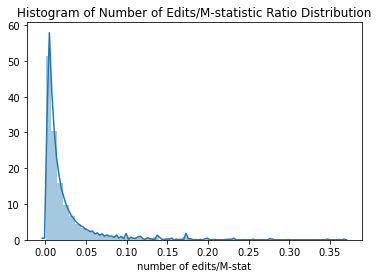

In [25]:
hs = sns.distplot(log_m/nonzero['num_edits'], axlabel = "number of edits/M-stat")
hs.set_title('Histogram of Number of Edits/M-statistic Ratio Distribution',
             fontsize=12);

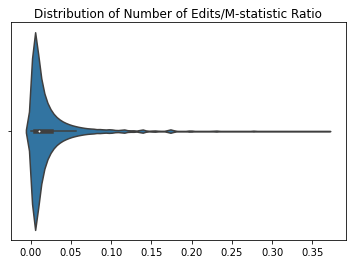

In [26]:
vp = sns.violinplot(log_m/nonzero['num_edits'])
vp.set_title('Distribution of Number of Edits/M-statistic Ratio',
             fontsize=12);